# Calculating sums and averages
Workflow that describes how to calculate the statistics of the elastic properties in a set of intervals / zones, for a set of wells. The result is stored in a RokDoc *Sums and Averages* excel file, which can be used in RokDoc after converting the result file from *.xlsx* to *.xls*

## Project table
The Excel sheet *project_table.xlsx*, in the *excels* folder of the install directory, is the important hub for which wells, and well logs, to use.



<img src="images/ProjectTable.png" />

In [1]:
import os
import utils.io as uio
import core.well as cw
from utils.calc_stats import calc_stats2 as calc_stats
from core.well import Project
from plotting import plot_rp

## Create a wells project


In [2]:
wp = Project(name='MyProject', tops_file='test_data/RokDocTops.xlsx', tops_type='rokdoc')

*Project* also take keywords:
- *working_dir* - the folder where the project is situated
- *project_table* - full or relative path name of the project table (.xlsx) explained in the top of this notebook
- *log_to_stdout* - if True, logging information is sent to standard output, else to a text file
- *tops_type* - tells the project what kind tops that are in use: *rokdoc*, *petrel* or *npd*

By default, none of these need to set, and it uses the install directory, toghether with example data and project table there

## Load project table


In [3]:
#well_table = uio.project_wells(wp.project_table, wp.working_dir)
wells = wp.load_all_wells()

0 WELL_A test_data/Well A.las
1 WELL_B test_data/Well B.las
2 WELL_C test_data/Well C.las


In [4]:
#for well in wells.values():
#    print(well.log_names())
#    well.depth_plot('Volume')

Load the project templates

In [6]:
templates = uio.project_templates(wp.project_table)s

['Resistivity', 'P velocity', 'S velocity', 'Permeability', 'VpVs', 'AI', 'Porosity', 'Volume', 'Saturation', 'Density', 'Caliper', 'Gamma Ray', 'Sonic', 'Shear sonic', 'TOC', 'Vitr. refl.', 'Hydrogen index', 'Production index', 'WELL_A', 'WELL_B', 'WELL_C', 'WELL_E', 'WELL_F']


## Load tops or working intervals
Well tops can either be handled by loading a file with well tops. They can be in format exported from Petrel, npd.no, or RokDoc.

Or you can define working intervals in the *Working intervals* sheet of the project table

<img src="images/ProjectTable_working_intervals.png" />

In the above example, the working intervals are defined through
- *Column A*: **Use** 
 - This column in not is use in the current version
- *Column B*: **Given well name**
 - Is the name of wells in the project, as defined in the *Wells table* sheet.  
- *Column C*: **Interval name**
 - name of the working interval
- *Column D & E*: **Top depth** & **Base depth**
 - Depth in meters MD to top and base of the working interval
 
The first five rows of this sheet should not be modified.

Load the working intervals through

In [7]:
wis = uio.project_working_intervals(wp.project_table)

Or load the tops directly from file

In [ ]:
tops = uio.read_tops(wp.tops_file, frmt=wp.tops_type)
#print('The tops file contains following wells and tops:')
for well in list(tops.keys()):
    print(' Well: {}'.format(well))
#    for ttop in list(tops[well].keys()):
#        print('  - {}'.format(ttop))

   # Calculate RokDoc compatible Sums & Averages
  This functionality is useful when you want to analyze the statistics of several formations / intervals across multiple wells (.las files).
  The results is saved as an .xlsx spreadsheet, with statistics of the rock properties. To be read by RokDoc, it has to be converted to .xls

Tell python where to save the results, where to find the wells, and the tops file

If the .xlsx file exists, it will be appended to.

If you want to save the results, or load the data from, elsewhere on your file system, please provide the full path name, using "forward slashes".

In the folder of where the .xlsx file is situated, all QC plots will be saved. Their name will end with the below 'tag'

In [ ]:
rd_file = 'results_folder/RokDoc_SumsAverages_from_python.xlsx'

tag = 'my_test'

Modify the project_table.xlsx so that it points to the wells; Well_A, Well_B and Well_C

<img src="images/ProjectTable.png" />


Log names under each log types *P velocity*, *S velocity*, *Density*, *Porosity*, and *Volume* must be specified, else the output to RokDoc Sums and Averages will fail.

Multiple log names can be specified under each log type (e.g. *Vp* and *Vp_dry*), but only one log per log type can be used in the statistics.

Therefore we need a table to specify which log to use under each log type


In [8]:
log_table = {'P velocity': 'vp_dry', 'S velocity': 'vs_dry', 'Density': 'rho_dry', 'Porosity': 'phie', 'Volume': 'vcl'}

Determine which working intervals you'd like to calculate the statistics for

In [ ]:
wi_sands = ['Sand H', 'Sand F', 'Sand E', 'Sand D', 'Sand C']
wi_shales = ['Shale G', 'Shale C']

Alternatively, define the tops you like to calculate the statistics over.
 - 'name' is an arbitrary name used when writing the sums & averages to file
 - 'tops' is a list of formation / interval names of the top and base that defines the interval of interest. For the calculation to work, these names have to exist in the above defined tops_file, for the given wells. 

In [ ]:
intervals_sands = [
            {'name': 'Sand H',
             'tops': ['Top H', 'Base H']},        
            {'name': 'Sand F',
             'tops': ['Top F', 'Base F']},
            {'name': 'Sand E',
             'tops': ['Top E', 'Top F']},
            {'name': 'Sand D',
             'tops': ['Top D', 'Top E']},
            {'name': 'Sand C',
             'tops': ['Top C', 'Top D']}
]
intervals_shales = [
    {'name': 'Shale C',
         'tops': ['Top C', 'Top D']},
    {'name': 'Shale G',
         'tops': ['Top G', 'Top H']}
]

Test to see if the above intervals are present in all wells

In [ ]:
for intervals in [intervals_sands, intervals_shales]:
    for key in list(wells.keys()):
        for top_name in [x['tops'][0].upper() for x in intervals]:
            if top_name not in list(tops[key].keys()):
                print('Top: {}, not present in well {}'.format(top_name, key))
        for base_name in [x['tops'][1].upper() for x in intervals]:
            if base_name not in list(tops[key].keys()):
                print('Base: {}, not present in well {}'.format(base_name, key))

Define the cut offs that are used to classify the data (e.g. sands or shales).
The statistics will only be calculated within each interval, where the cut off is valid
The log names (e.g. *vcl*) corresponding to a log type (e.g. *Volume*) must exist in the .las files

In [9]:
cutoffs_sands = {'Volume': ['<', 0.5], 'Porosity': ['>', 0.1]}
cutoffs_shales = {'Volume': ['>', 0.5], 'Porosity': ['<', 0.1]}

Try plotting some data

WELL_A
['SAND C', 'SHALE C', 'SAND D', 'SAND E', 'SAND F', 'SHALE G', 'SAND H']
WELL_B
['SAND C', 'SHALE C', 'SAND D', 'SAND E', 'SAND F', 'SHALE G', 'SAND H']
WELL_C
['SAND C', 'SHALE C', 'SAND D', 'SAND E', 'SAND F', 'SHALE G', 'SAND H', 'TOP I']


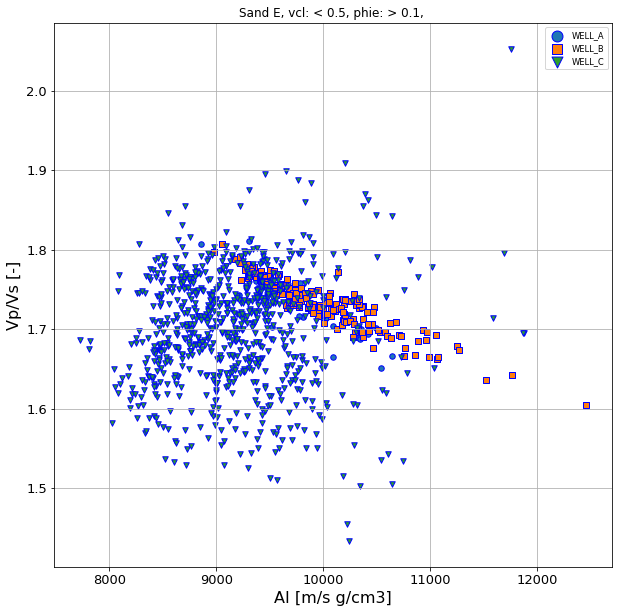

In [10]:
plot_rp.plot_rp(
    wells,
    log_table,
    wis,
    'Sand E',
    cutoffs_sands,
    templates,
    show_masked=True,
    edge_color=False
)

Run the calculation of the statistics

In [ ]:
calc_stats(wells, log_table, wis, wi_sands, cutoffs_sands, 
              rokdoc_output=rd_file,
              working_dir=os.path.join(wp.working_dir, 'results_folder'),
              suffix=tag)

In [ ]:
calc_stats(wells, log_table, tops, intervals_shales, cutoffs_shales, 
              rokdoc_output=rd_file,
              working_dir=os.path.join(wp.working_dir, 'results_folder'),
              suffix=tag)